In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))

In [4]:
OBS2.keys()

dict_keys(['q650', 'hour', 'u925', 'pv925', 'pv650', 'w925', 'rh925', 'v650', 'p', 'month', 'div925', 't650', 'pgt01isvalid', 'clon', 't925', 'year', 'tmean', 'shear', 'div650', 'lon', 't', 'pmax', 'pmean', 'q925', 'rh650', 'clat', 'w650', 'tmin', 'pgt30', 'v925', 'area', 'u650', 'lat'])

In [6]:
np.unique(OBS2['month'])

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])

In [5]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [186]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [233]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.3)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3)]# & (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.3)]


In [234]:
obs_gpm

,area,lat,lon,month,prcp,q650,q925,shear,t650,t925,tmean,tmin,u650,u925
0,15175,8.042260,7.086056,7,16.436291,6.616410,14.771931,4.242306,5.643030,20.572961,-59.368354,-66.000000,-0.871464,3.370841
1,8625,5.251607,11.170472,8,4.185770,7.055621,16.826462,-0.868521,5.181268,21.302759,-59.640201,-68.415718,3.606708,2.738187
2,5050,6.118873,-0.763059,11,25.979994,1.884424,15.512910,5.897785,5.504205,23.212488,-63.932756,-76.043866,-4.892231,1.005554
4,12700,5.550144,11.265918,8,16.874041,8.860437,15.085265,1.735940,5.881128,20.655878,-57.706569,-71.352158,-1.495301,0.240639
5,13525,5.638003,8.894604,7,37.000000,7.402976,15.771469,13.880902,5.241998,20.648157,-59.519781,-78.053550,-12.106024,1.774879
6,10425,6.153120,6.669265,4,2.228098,4.325093,15.239720,9.383993,5.768335,24.142786,-62.305062,-70.000000,-6.770352,2.613641
7,5350,7.869163,5.653593,7,10.723988,7.174695,14.604548,10.601906,5.975610,20.208582,-56.795472,-65.765055,-6.966541,3.635365
8,10850,5.454751,11.438341,5,14.134404,5.217465,15.294153,6.155697,7.378290,24.323053,-74.656591,-86.000000,-6.902615,-0.746918
9,10525,5.870359,8.322838,7,1.267474,6.686833,14.475948,10.404615,5.120508,23.035120,-56.181945,-67.069013,-9.873000,0.531615
11,12550,7.627684,-2.724923,10,2.670303,5.609727,14.941356,8.342429,5.652673,22.745905,-59.930664,-67.654924,-11.107446,-2.765016


In [235]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.202033158482649 8.27489747441562 -9.903745996969064 11.95447649051051
OBS_trmm 5.202948463139375 8.299489120459318 -9.985909169988865 11.952369398805448
OBS_gpm 5.200651754466874 8.299464319878636 -9.999797285878543 11.796071028573365


In [236]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, '-0.53')

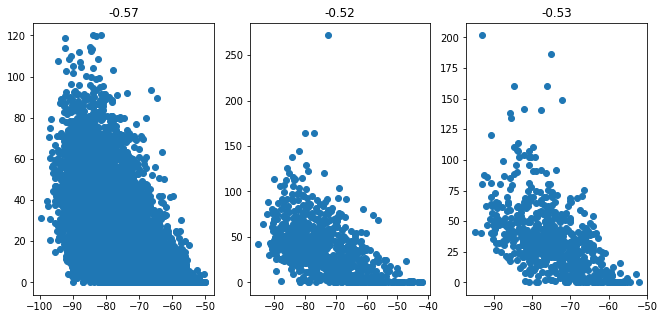

In [237]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [238]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [239]:
ts=pd.Series(np.array(era_out['dates']))

In [240]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [241]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [242]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [243]:
ds = ds[(ds.lon>=-10)&(ds.lon<=12)&(ds.lat>=5)&(ds.lat<=8)]

In [244]:
ds = ds.dropna()

In [245]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.6300048828125 -9.970001220703125
4921.070000000001
75
4400
1452.0000000000002


In [246]:
pos1 = (ds.u650<0) & (ds.area>=5000)# all storms, without trmm overpass - matchup via storm centre points

In [247]:
np.sum(pos1)

11481

In [1712]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=1) #& ((obs_gpm.month!=8))# | (obs_gpm.month>=9))


#((obs_gpm.month>=9) & (obs_gpm.month<=11) | ((obs_gpm.month<=6) & (obs_gpm.month>=2)))

In [1713]:
ds_march = ds[pos1]
obsp = obs_gpm[oposi]

In [1714]:
obsp.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

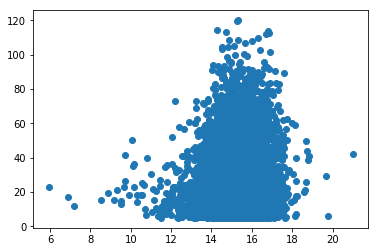

In [1715]:
pos = obsp.prcp > 5
plt.scatter(obsp.q925[pos], obsp.prcp[pos])

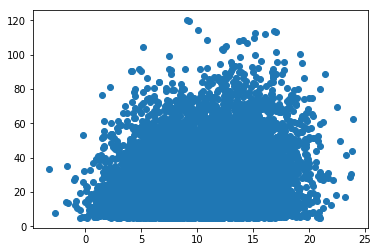

In [1716]:
plt.scatter(obsp.shear[pos], obsp.prcp[pos])

In [2382]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbq) 
#
nbqq = 7
nbss = 7

p1 = 1
p2 = 99

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, p1) , np.percentile(obsp.q925, p2), nbqq)


In [2393]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
#             outperc_tt[-3,0] = np.nan
#             outperc_pp[-3,0] = np.nan
            
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [2394]:
def hist2d_three(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,4))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,3,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
 
        if valid:
            
            dat['data'][dat['valid']<15] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [2395]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [2396]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [2397]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.781728921405445
15.630504314872617


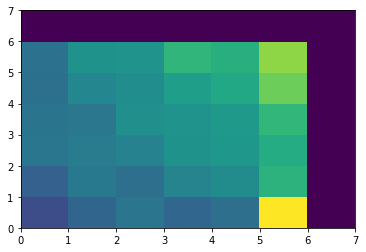

In [2398]:
plt.pcolormesh(pcobs.T)

In [2399]:
# tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
#     'title' : 'Median minimum temperature',
#     'valid' : dsval_mar,
#     'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
#     'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
#     'xlabel' : 'Wind shear (m s$^{-1}$)'
# }

tmin_dic = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median minimum temperature',
    'valid' : obsval,# dsval_mar,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [2400]:
data_list = [tmin_dic, prcp_dic, area_dic]

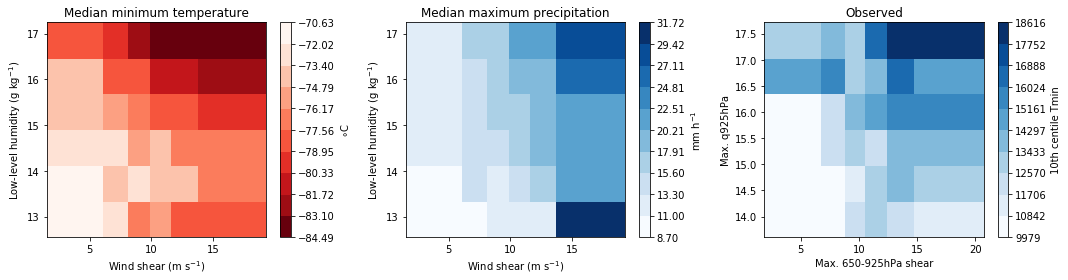

In [2401]:
hist2d_three(data_list, valid=True)

In [2402]:
alln=9
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.linspace(np.percentile(ds_march.shear, 1) , np.percentile(ds_march.shear, p2), nbs) 

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.percentile(ds_march.q925[(ds_march.q925>=np.percentile(ds_march.q925,p1)) & \
                                            (ds_march.q925<=np.percentile(ds_march.q925,p2))], \
                             np.linspace(0,100,nbq)) 

nbqq = 9
nbss = 9

p1 = 2
p2 = 99

shear_obsp = np.linspace(np.percentile(obsp.shear, 1) , np.percentile(obsp.shear, p2), nbss) #np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.percentile(obsp.q925[(obsp.q925>=np.percentile(obsp.q925,p1)) & (obsp.q925<=np.percentile(obsp.q925,p2))], np.linspace(0,100,nbqq)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))



In [2403]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [2404]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [2405]:
tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median minimum temperature',
    'valid' : obsval,# dsval_mar,
    'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [2406]:
data_list = [tmin_dic, prcp_dic, area_dic]

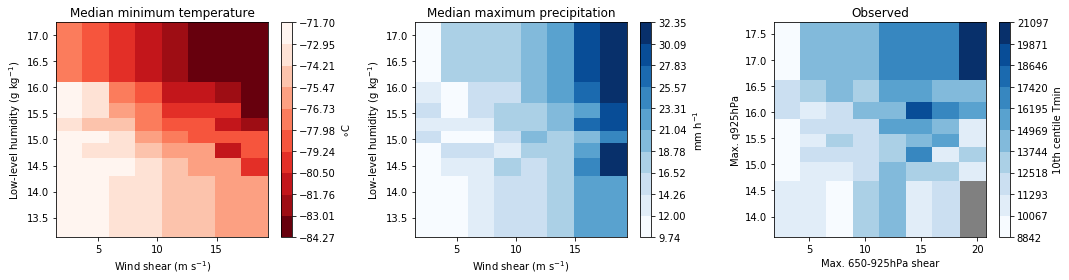

In [2407]:
hist2d_three(data_list, valid=True)

In [2408]:
alln=9
nbs= alln
nbq= alln
nba = alln

p1 = 2 #5
p2 = 99

shearb_march = np.linspace(np.percentile(ds_march.shear, p1) , np.percentile(ds_march.shear, p2), nbs) 

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbs) 

nbqq = 9
nbss = 9

p1 = 1
p2 = 99

shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss) #np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, p1) , np.percentile(obsp.q925, p2), nbss) #np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

# shear_obsp = np.linspace(0 , 18, 7) #np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

# qbinso = np.linspace(13.5 , 17.5, 7) 

In [2409]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [2410]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [2411]:
tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median minimum temperature',
    'valid' : obsval,# dsval_mar,
    'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [2412]:
#prcp_dic['data'][-2,3] += 3

In [2413]:
data_list = [tmin_dic, prcp_dic, area_dic]

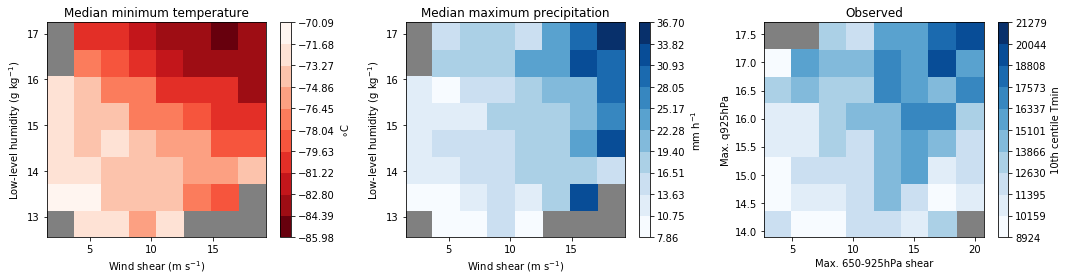

In [2414]:
hist2d_three(data_list, valid=True)

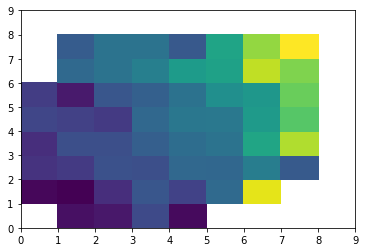

In [2415]:
plt.pcolormesh(prcp_dic['data'].T)


In [2416]:
prcp_dic['data'].T

array([[        nan,  9.05583575,  9.64501565, 13.84318597,  8.6396932 ,
                nan,         nan,         nan,         nan],
       [ 8.42117725,  7.92325026, 11.41069095, 14.99523141, 13.16686299,
        16.97244791, 33.23312261,         nan,         nan],
       [11.81115229, 12.3836219 , 14.48388278, 14.23811015, 16.69904831,
        16.6514243 , 19.05139037, 15.28439572,         nan],
       [11.36737506, 14.24675308, 14.23038198, 15.85929215, 17.27613174,
        17.97979533, 23.4652476 , 31.21298248,         nan],
       [13.41178424, 12.99445558, 12.418129  , 16.74949609, 18.42740585,
        18.55077896, 22.25785712, 27.38826688,         nan],
       [12.57147561,  9.68528575, 14.9838285 , 15.90339307, 17.91348846,
        20.95988941, 21.95637918, 28.27652152,         nan],
       [        nan, 16.81497921, 18.01370592, 19.24006146, 22.36633864,
        23.00439424, 31.85605147, 29.18663614,         nan],
       [        nan, 15.48025414, 17.97937099, 18.00350376, 15